# CSE 291 Homework2 - Random Forests and Boosting  

#### Chao Yu 
#### Wen Liang A53214852

## Random Forests
---
### Covertype
#### Part 1. Read the data and split to training and test sets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, zero_one_loss

%config InlineBackend.figure_format='svg'
%matplotlib inline

In [2]:
covertype_path = './covtype/covtype.data'

names = [
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points',
]

Wilderness_Area = []
for i in range(4):
    Wilderness_Area.append('Wilderness_Area_{}'.format(i+1))

Soil_Type = []
for i in range(40):
    Soil_Type.append('Soil_Type_{}'.format(i+1))

names.extend(Wilderness_Area + Soil_Type + ['Cover_Type'])
covertype_df = pd.read_csv(covertype_path, names=names)

In [3]:
covertype_df.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points     ...      Soil_Type_32  Soil_Type_33  \
0                                6279     ...                 0             0   
1                                6225     ...                 0             0   
2                                6121     ...                 0             0   
3                                6211     ...                 0             0   
4                                6172     ...                 0             0   

   Soil_Type_34  Soil_Type_35  Soil_Type_36  Soil_Type_37  Soil_Type_38  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   Soil_Type_39  Soil_Type_40  Cover_Type  
0             0             0           5  
1             0             0           5  
2             0             0           2  
3             0             0           2  
4             0             0           5  

[5 rows x 55 columns]

In [4]:
X = covertype_df.drop('Cover_Type',axis=1)
y = covertype_df['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25, random_state=42)

We found that this dataset is dominated by class 1 and class 2 and this can mislead the training process of our classifiers so we choose to slightly balance it by square root their ratio.

In [5]:
# now I balance the dataset
# get the number for each classes
classes = list(set([row[-1] for row in covertype_df.as_matrix()]))

In [6]:
count = [0] * 7
for row in covertype_df.as_matrix():
    count[row[-1] - 1] += 1

Count for each classes before balance

In [7]:
count

[211840, 283301, 35754, 2747, 9493, 17367, 20510]

In [8]:
balanced_data = []
import random
import math
for row in covertype_df.as_matrix():
    if random.random() < math.sqrt(2747.0 / count[row[-1] - 1]):
        balanced_data.append(row)

Count for each classes after balance

In [9]:
count2 = [0] * 7
for row in balanced_data:
    count2[row[-1] - 1] += 1
print count2

[23853, 27831, 9854, 2747, 5231, 6935, 7517]


In [10]:
train, test = train_test_split(balanced_data, test_size=0.25, random_state=42)

In [11]:
len(train[0])

55

In [25]:
X_train, X_test, y_train, y_test = train_test_split(np.array(balanced_data)[:, 0:-1], np.array(balanced_data)[:, -1], test_size=0.25, random_state=42)

methods:
* two_split: split the data into 2 split using a pivot
* entropy: compute the entropy
* entroypy_compute: compute the information gain
* get_split: go through the dataset, randomly choose some features, go through all the splits, find the best one and return
* to_terminal: set the decision on the leaves
* split: split branches from a node
* build_tree: build a tree from root
* predict: get prediction with the tree and observed data
* resample: resample the dataset by the resample ratio
* bagging_predict: get prediction for the forests
* random_forest: build a random forest

In [16]:
from random import randrange
from math import log
import random

def two_split(index, value, dataset):
    left = []
    right = []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right


def entropy(dataset, classes):
    size = len(dataset)
    if size == 0:
        return 0
    ent = 0.0
    count = [0.0] * len(classes)
    for data in dataset:
        count[classes.index(data[-1])] += 1
    for c in count:
        proportion = c / size
        if proportion != 0:
            ent += -proportion * log(proportion, 2)
    return ent

def entropy_compute(groups, classes):
    dataset = []
    for group in groups:
        dataset += group
    # information for this node
    ent_I = entropy(dataset, classes)
    # information required for subtrees / groups
    ent_remain = 0.0
    for group in groups:
        ent_temp = entropy(group, classes)
        ent_remain += (len(group)*1.0 / len(dataset)) * ent_temp
    return (ent_I - ent_remain)


def get_split(dataset, n_features):
    #X data, y label, n_feartures number of features you want
    features = [];
    classes = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 0, 0, None
    while b_groups is None:
        while len(features) < n_features:
            index = randrange(len(dataset[0]) - 1)
            if index not in features:
                features.append(index)
        for index in features:
            # get value range
            vals = set([row[index] for row in dataset])
            vals = list(vals)
            # if less than 10 classes, just use it
            # else compute 8 cuts
            if len(vals) > 10:
                low, high = min(vals), max(vals)
                diff = (high - low) / 11
                vals = [x * diff + low for x in range(0, 11)]
            for value in vals:
                groups = two_split(index, value, dataset)
                ent = entropy_compute(groups, classes)
                if ent > b_score:
                    b_index, b_value, b_score, b_groups = \
                        index, value, ent, groups
        # if has None situation, just print to see
        if b_groups == None:
            for index in features:
                # get value range
                vals = set([row[index] for row in dataset])
                vals = list(vals)
                # if less than 10 classes, just use it
                # else compute 8 cuts
                if len(vals) > 10:
                    low, high = min(vals), max(vals)
                    diff = (high - low) / 11
                    vals = [(x * diff + low) for x in range(0, 11)]
                print "here the values", vals
                for value in vals:
                    groups = two_split(index, value, dataset)
                    ent = entropy_compute(groups, classes)
                    if ent > b_score:
                        b_index, b_value, b_score, b_groups = \
                            index, value, ent, groups
                print "the entropy is", ent
    return {'index':b_index, 'value':b_value, 'groups': b_groups}

def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key = outcomes.count)

# creat child split
def split(node, max_depth, min_size, n_features, depth):
    left, right = node['groups']
    del(node['groups'])
    #print "the depth is", depth
    # check terminate
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left
    classes = list(set(row[-1] for row in (left + right)))
    if len(left) <= min_size or entropy(left, classes) < 0.01:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, n_features)
        split(node['left'], max_depth, min_size, n_features, depth+1)
    # process right,
    if len(right) <= min_size or entropy(right, classes) < 0.01:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, n_features)
        split(node['right'], max_depth, min_size, n_features, depth+1)

# build a decision tree
def build_tree(train, max_depth, min_size, n_features):
    root = get_split(train, n_features)
    split(root, max_depth, min_size, n_features, 1)
    return root

# prediction
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
        
# random sample -- bootstrap
def resample(dataset, ratio):
    sample = list()
    num = round(len(dataset) * ratio)
    while len(sample) < num:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

# predict
def bagging_predict(trees, row):
    decisions = [predict(tree, row) for tree in trees]
    return max(set(decisions), key = decisions.count)

# Random Forest
def random_forest(train, test, max_depth, min_size\
                 , sample_ratio, n_trees, n_features):
    trees = []
    for i in range(n_trees):
        samples = resample(train, sample_ratio)
        tree = build_tree(samples, max_depth, min_size, n_features)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test]
    return predictions


In [24]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Part 4. Find and Visualize the features importance

#### Part 2. Train 2 types of RFs
#### Part 3. Investigate the the number of trees
#### Part 5. Show the confusion matrix

In [17]:
trees = []

In [18]:
# build tree with max_depth 5
n_trees = 120
sample_ratio = 0.5
max_depth = 5
min_size = 25
n_features = 0.5 * len(train[0])

for i in range(n_trees):
    print("tree number " + str(i + 1))
    samples = resample(train, sample_ratio)
    
    tree = build_tree(samples, max_depth, min_size, n_features)
    trees.append(tree)

tree number 1
tree number 2
tree number 3
tree number 4
tree number 5
tree number 6
tree number 7
tree number 8
tree number 9
tree number 10
tree number 11
tree number 12
tree number 13
tree number 14
tree number 15
tree number 16
tree number 17
tree number 18
tree number 19
tree number 20
tree number 21
tree number 22
tree number 23
tree number 24
tree number 25
tree number 26
tree number 27
tree number 28
tree number 29
tree number 30
tree number 31
tree number 32
tree number 33
tree number 34
tree number 35
tree number 36
tree number 37
tree number 38
tree number 39
tree number 40
tree number 41
tree number 42
tree number 43
tree number 44
tree number 45
tree number 46
tree number 47
tree number 48
tree number 49
tree number 50
tree number 51
tree number 52
tree number 53
tree number 54
tree number 55
tree number 56
tree number 57
tree number 58
tree number 59
tree number 60
tree number 61
tree number 62
tree number 63
tree number 64
tree number 65
tree number 66
tree number 67
tree

In [26]:
# confusion matrix for trees depth 5
predictions = [bagging_predict(trees, row) for row in X_test];

from sklearn.metrics import confusion_matrix
import pylab as pl
accuracy = confusion_matrix(y_test,predictions)
print(accuracy)

[[4095 1586    4    0    1   27  296]
 [1616 4923  131    0    5  211   23]
 [   0  117 2048  165    0  158    0]
 [   0    0  113  557    0    1    0]
 [   0 1105   63    0  129   19    0]
 [   0  165  942   82    0  565    0]
 [ 520    8    0    0    0    0 1317]]


Confusion matrix, without normalization
[[4095 1586    4    0    1   27  296]
 [1616 4923  131    0    5  211   23]
 [   0  117 2048  165    0  158    0]
 [   0    0  113  557    0    1    0]
 [   0 1105   63    0  129   19    0]
 [   0  165  942   82    0  565    0]
 [ 520    8    0    0    0    0 1317]]


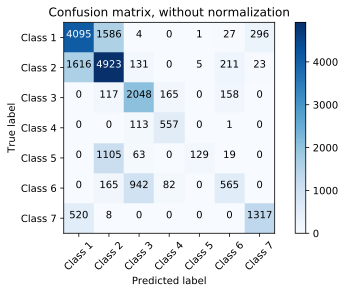

In [27]:
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')
plt.show()

In [28]:
# error rate method
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))
# plot the error rate
def plot_error_rate2(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,200,20))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

In [31]:
pred_train = [bagging_predict(trees, row) for row in X_train]
pred_test = [bagging_predict(trees, row) for row in X_test]
print "test error rate: ", get_error_rate(pred_test, y_test)
print "training error rate: ", get_error_rate(pred_train, y_train)

test error rate:  0.350514481707
training error rate:  0.350085746951


In [32]:
# investigate the number of trees
nums = [1, 20, 40, 60, 80, 100, 120]
err_train = []
err_test = []
for n in nums:
    # compute number of errors in each number of trees
    count = 0
    pred_train = [bagging_predict(trees[0:n], row) for row in X_train]
    pred_test = [bagging_predict(trees[0:n], row) for row in X_test]
    err_train.append(get_error_rate(pred_train, y_train))
    err_test.append(get_error_rate(pred_test, y_test))

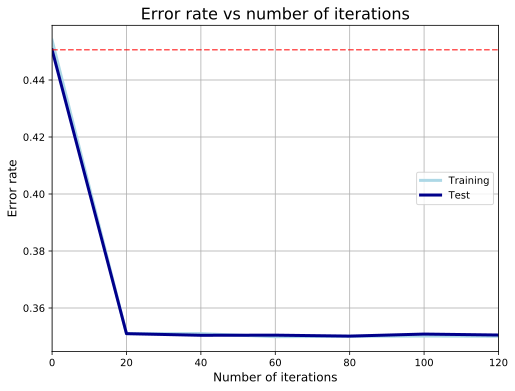

In [33]:
plot_error_rate2(err_train, err_test)

We choose 40 as a reasonable number where the errors reach a plateau. We have tried the unbalanced data (forget to save the figure) and this require more (about 80) trees in the forest. I think the reason is that the random forests algorithm is very sensitive to the quality of data you have and the skewness of data is a important charactor.

Our decision tree is only 2 splits so the depth = 5 is not a proper parameter. Then we want to show the result with depth = 15

In [34]:
trees_15 = []

In [ ]:
# build tree with max_depth 15
n_trees = 40
sample_ratio = 0.5
max_depth = 15
min_size = 25
n_features = 0.5 * len(train[0])

for i in range(n_trees):
    print("tree number " + str(i + 1))
    samples = resample(train, sample_ratio)
    
    tree = build_tree(samples, max_depth, min_size, n_features)
    trees_15.append(tree)

tree number 1
tree number 2
tree number 3
tree number 4
tree number 5
tree number 6
tree number 7
tree number 8
tree number 9
tree number 10
tree number 11
tree number 12
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [1]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the values [0]
the entropy is 0.0
here the v

In [ ]:
# test predictions for trees depth 15
predictions = [bagging_predict(trees_15, row) for row in X_test];
accuracy = confusion_matrix(y_test,predictions)
print(accuracy)

In [ ]:
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
pred_train = [bagging_predict(trees_15, row) for row in X_train]
pred_test = [bagging_predict(trees_15, row) for row in X_test]
err_train.append(get_error_rate(pred_train, y_train))
print "test error rate: ", get_error_rate(pred_test, y_test))
print "training error rate: ", get_error_rate(pred_train, y_train))

full extent trees

In [ ]:
# build tree with max_depth 100
trees_full = []
n_trees = 40
sample_ratio = 0.5
max_depth = 100
min_size = 25
n_features = 0.5 * len(train[0])

for i in range(n_trees):
    print("tree number " + str(i + 1))
    samples = resample(train, sample_ratio)
    
    tree = build_tree(samples, max_depth, min_size, n_features)
    trees_full.append(tree)

In [ ]:
# test predictions for trees depth 15
predictions = [bagging_predict(trees_full, row) for row in X_test];
accuracy = confusion_matrix(y_test,predictions)
print(accuracy)

In [ ]:
labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7']
plt.figure()
plot_confusion_matrix(accuracy, classes=labels,
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
pred_train = [bagging_predict(trees_full, row) for row in X_train]
pred_test = [bagging_predict(trees_full, row) for row in X_test]
err_train.append(get_error_rate(pred_train, y_train))
print "test error rate: ", get_error_rate(pred_test, y_test))
print "training error rate: ", get_error_rate(pred_train, y_train))

#### Part 6. Plot errors

#### Part 7. Comment on the trends you observed with increasing B for the two types of RFs. 

## Boosting
---
### Covertype
#### Part 1. data preprocessing (already done)
#### Part 2. Implement Adaboost with 2 types of training and test sets

methods:
* adaboost_clf2: multiclass adaboost algorithm, M - number of weak classifiers, Max_depth - max depth of decision tree, Min_split - min split of decision tree
* plot_error_rate: plot the error rate

In [ ]:
import math
def adaboost_clf2(y_train, X_train, y_test, X_test, M, Max_depth, Min_split):
    n_train, n_test = len(X_train), len(X_test)
    err_test, err_train = [], []
    classes = list(set(y_train))
    n_class = len(classes)
    # initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = np.zeros((n_train, n_class)), np.zeros((n_test, n_class))
    for i in range(M):
        
        clf = DecisionTreeClassifier(max_depth=Max_depth, min_samples_split=Min_split, random_state=42)
        clf.fit(X_train, y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        
        miss1 = [int(x) for x in (pred_train_i != y_train)]
        err_m = np.dot(w,miss1) / sum(w)
        #print err_m
        alpha_m = np.log((1-err_m) / float(err_m)) + math.log(n_class - 1)
        #print alpha_m
        
        miss2 = [x if x == 1 else -1 for x in miss1]
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        w = w / sum(w)
        #print miss1
        #print miss2
        #print w
        # update
        for i in range(n_train):
            cls = pred_train_i[i]
            idx = classes.index(cls)
            pred_train[i, idx] += alpha_m
        for i in range(n_test):
            cls = pred_test_i[i]
            idx = classes.index(cls)
            pred_test[i, idx] += alpha_m
        
        # get the prediction
        prediction_train = [classes[np.argmax(row)] for row in pred_train]
        #print 'the prediction', prediction_train
        #print 'the y train', y_train
        prediction_test = [classes[np.argmax(row)] for row in pred_test]
        
        # compute current error rate
        err_train.append(get_error_rate(prediction_train, y_train))
        err_test.append(get_error_rate(prediction_test, y_test))
    # confusion matrix
    from sklearn.metrics import confusion_matrix
    accuracy = confusion_matrix(y_test,prediction_test)
    print(accuracy)
    return err_train, err_test

In [ ]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

#### Part 3. Investigate number of iterations - M
#### Part 4. Confusion matrix
#### Part 6. For each of the two types plot the training error, test error, w.r.t. the number of iterations.

In [ ]:
# type one, depth = 1
err_train, err_test=adaboost_clf2(y_train, X_train, y_test, X_test, 200, 1, 2)
plot_error_rate(err_train, err_test)

In [ ]:
# type two, depth = 10
err_train2, err_test2, clfs2, alphas2=adaboost_clf2(y_train, X_train, y_test, X_test, 200, 10, 2)
plot_error_rate(err_train2, err_test2)

#### Part 5.Analyze and explain the trends you noted that may justify your results and parameter choices

#### Part 7. Comment on the trends you observed with increasing iterations for the two types of learners